# Rev.ai Microphone Stream output
Instead of using google's speech recognition API
## Importing Relavent Modules

In [1]:
import threading
import numpy as np
import time
import ipywidgets as ipw
from matplotlib import pyplot as plt
import queue
import cv2
import os

from rev_ai.models import MediaConfig
from rev_ai.streamingclient import RevAiStreamingClient
from PPFunctions_Live import *

## Hardware Constraints for Board:

In [2]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
base = BaseOverlay("base.bit")

pAudio = base.audio
pAudio.set_volume(20)
pAudio.select_microphone() # using AUX cable connected to Headphones as microphone input

## Defining File to Write Output To:

In [3]:
no_files = str(len(os.listdir('./SubtitledContent')))
cwd = os.getcwd()
file = 'TextOutput_' + no_files + '.json'

filename = os.path.join(cwd, 'SubtitledContent', str(file))
f = open(filename, "x")

## Frame for Subtitles to be Displayed:
Making a blank black box to overlay text at a later point. Functions used are within PPFunctions_Live.py!

## Defining Blank Subtitle Field:

In [4]:
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

# Dummy image to overlay ontop of:
overlay_frame = np.zeros((frame_in_h, frame_in_w), np.uint8)
img = overlaid_image(overlay_frame)

## Test Block:

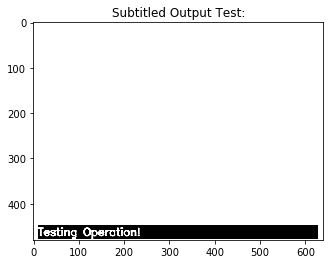

In [5]:
# Fake subtitles:
sub = "Testing Operation!"

# Calling Functions:
image = overlaid_image(overlay_frame)
image_test = sub_output(sub, image)

# Displaying Image:
plt.imshow(image_test)
plt.title('Subtitled Output Test:')
plt.show()

# Defining Microphone Stream
Threaded class used to process audio into subtitles in real-time. Code based upon example from Strath-SDR RFSoC QPSK and rev.ai sample python code.
## Audio Thread:

In [6]:
class AudioThreading():
    def __init__(self, pynq_audio, record_time, chunk, start=True, src=0):
        """
        Create new dma-based data timer.
        callback: function to call with data chunk
        gen: function to call to return data chunk
             (usually a dma channel's transfer function)
        """
        self.stopping = not start
        self.record_time = record_time
        self._buffer = queue.Queue()
        self._pynq_audio = pynq_audio
        self.chunk = chunk
        self.closed = True
        
        self.stopped = False

    def _do(self):
        """
        Generate new data and restart timer thread.
        Should never be run directly. use `start()` instead.
        """
        while not self.stopping:
            self._pynq_audio.record(self.record_time)
            self._buffer.put(self._pynq_audio.buffer << 8)

    def __enter__(self):
        
        self._audio_interface = self._pynq_audio
        
        """ Start the data generator thread. """
        if not self.stopping:           
            self.stopping = False
            thread = threading.Thread(target=self._do)
            thread.start()
            
        self.closed = False
        return self
    
    def __exit__(self, type, value, traceback):
        """
        Stop a running data generator thread.
        Does not need a lock, since the spawned timer thread will only read `self.stopping`.
        """
        self.stopped = True
        self.closed = True
        self._buffer.put(None)
    
    # Rev.ai Code example for microphone stream:
    def generator(self):
        while not self.stopping:
            """
            Use a blocking get() to ensure there's at least one chunk of
            data, and stop iteration if the chunk is None => stop on pause!
            """
            chunk = self._buffer.get()
            if chunk is None:
                return
            data = [chunk]

            while True:
                try:
                    chunk = self._buffer.get(block=False)
                    if chunk is None:
                        return
                    data.append(chunk)
                except queue.Empty:
                    break

            yield b''.join(data)

## Personal Access Token for Rev.ai:

In [7]:
access_token = "020xN8wEvpFJ57K5xz4CjnhKVkC0kDJO74fKvx58chPRJQHUChMfrQyTWWooMnfO5H5kyGiVdHJHSroppSQFIU9g69v2E"

## Routing Audio Through Logic Fabric:
Sampling rate of Audio Codec

In [8]:
rate = 48 * 1000 # Technically, codec is 96 kHz, however two channels will be used
chunk = int(rate/20000) # Approx 4s

## Raw Microphone Input to Create Media Config:
96 kHz interleaved, signed 32-bit, dual channel audio

In [9]:
example_mc = MediaConfig('audio/x-raw', 'interleaved', rate, 'S32LE', 2) 
streamclient = RevAiStreamingClient(access_token, example_mc)

## Opens microphone input, input will stop after a keyboard interrupt:

new chunk!
Connected, Job ID : iGxImBAAtQAG1TO6


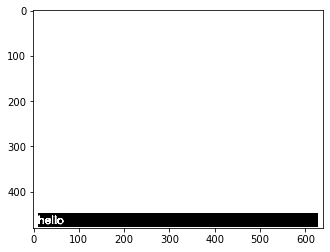

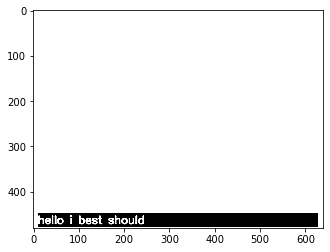

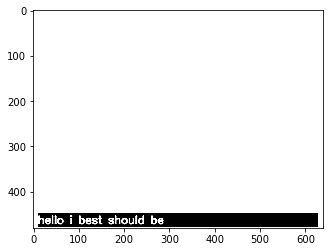

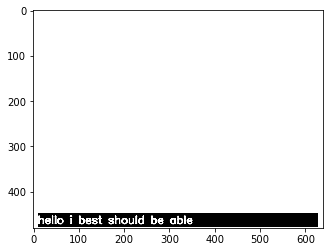

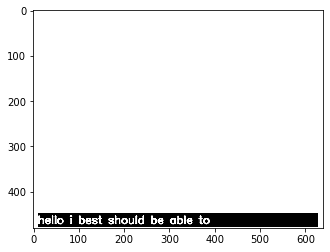

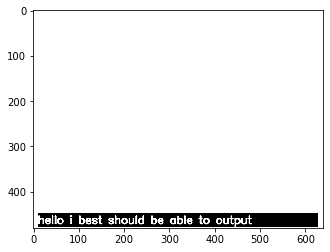

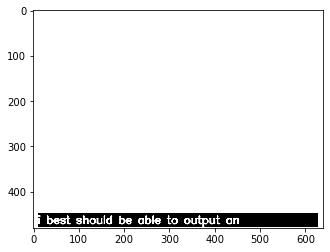

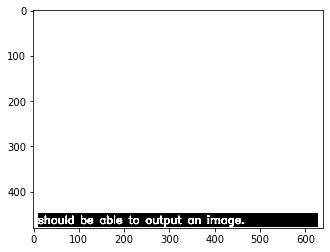

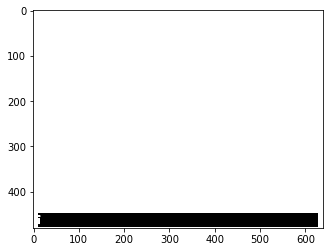

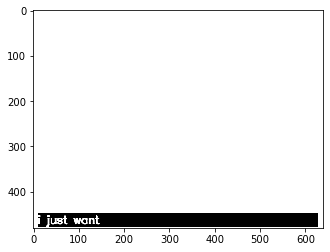

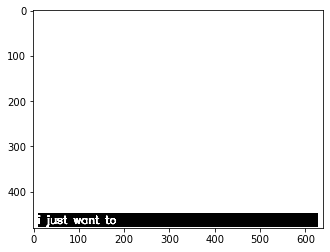

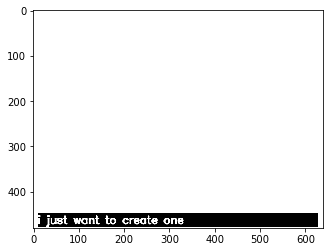

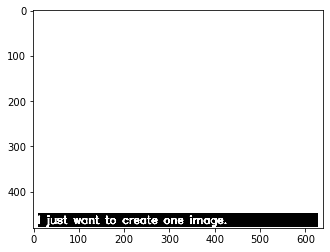

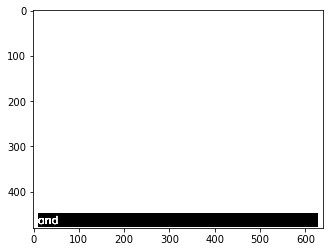

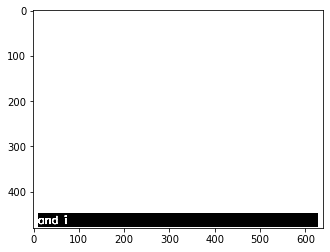

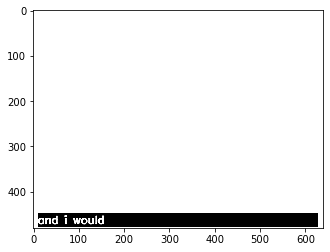

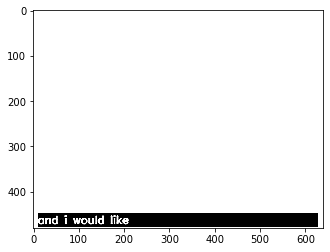

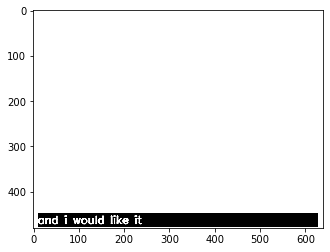

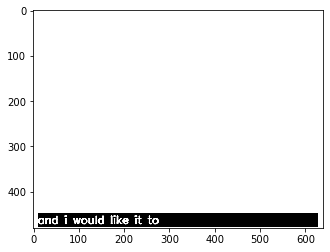

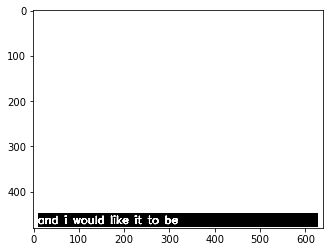

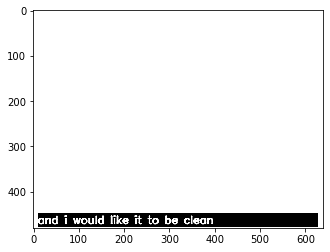

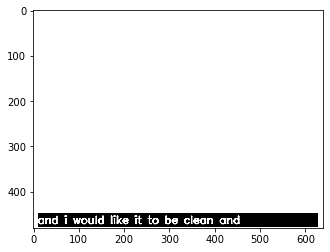

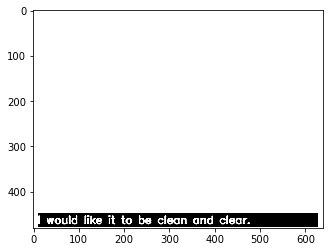

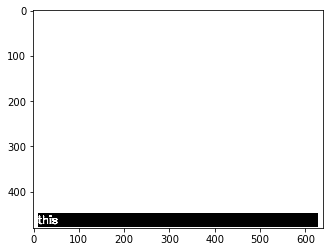

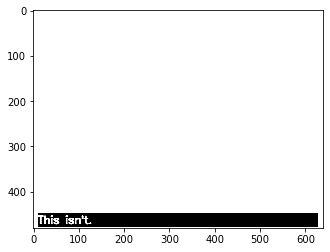

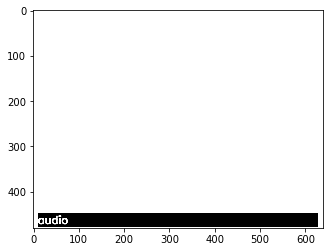

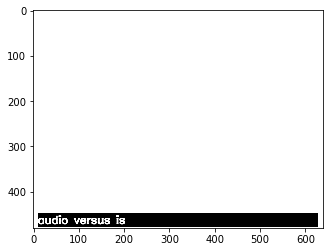

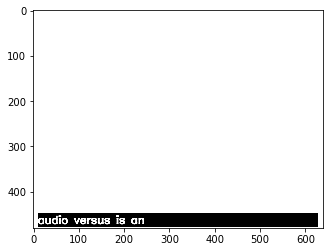

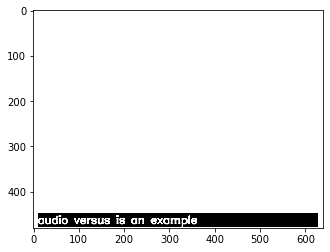

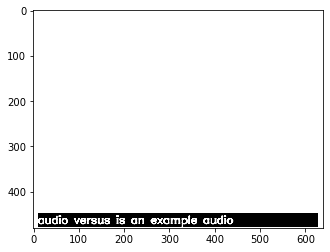

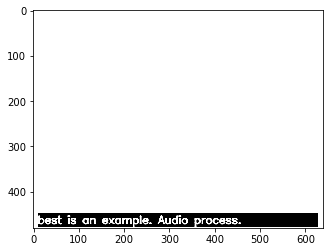

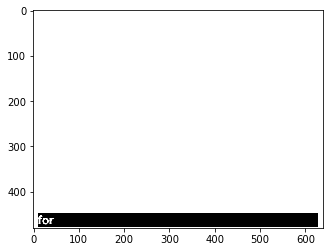

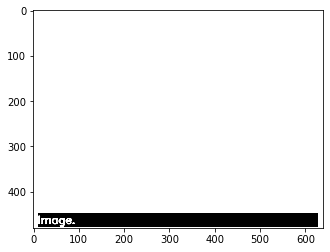

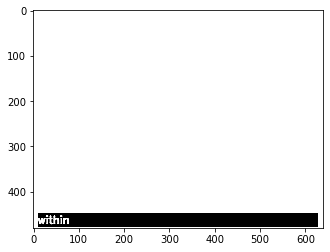

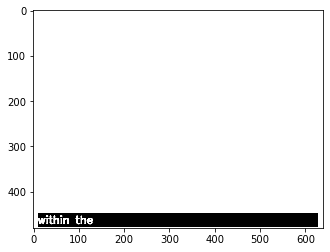

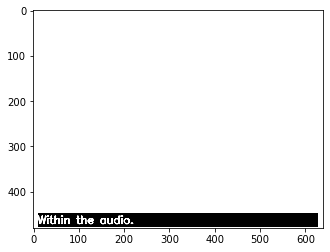

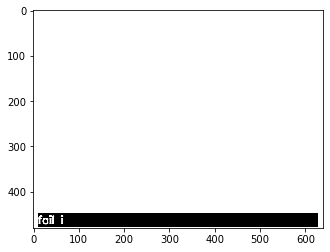

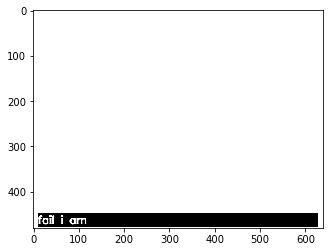

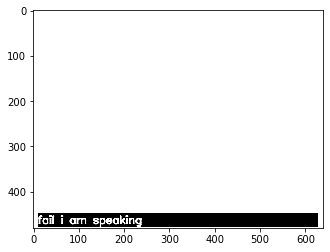

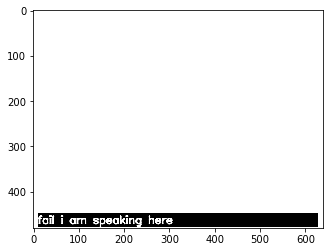

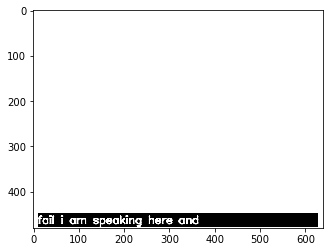

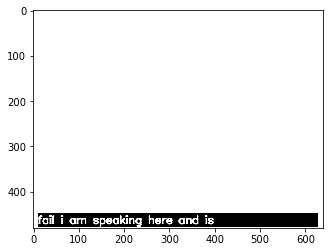

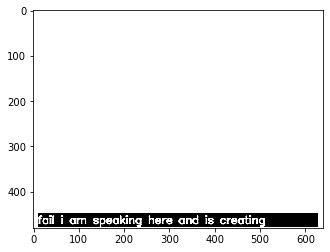

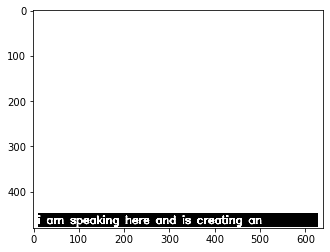

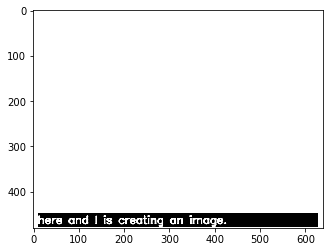

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/rev_ai/streamingclient.py", line 169, in _send_data
    self.client.send("EOS")
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/websocket/_core.py", line 283, in send
    return self.send_frame(frame)
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/websocket/_core.py", line 311, in send_frame
    l = self._send(data)
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/websocket/_core.py", line 512, in _send
    return send(self.sock, data)
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/websocket/_socket.py", line 167, in send
    return _send()
  File "/usr/local/share/pynq-venv/lib/python3.8/site-packages/websocket

In [10]:
sub_prev = ''
    
with AudioThreading(pAudio, 1, chunk) as stream:
    
    try:
        ## Starts the server connection and thread sending microphone audio
        print("new chunk!")
        response_gen = streamclient.start(stream.generator())
        ## Iterates through responses and prints them
        for response in response_gen:
            sub = real_t(response)
            if sub != sub_prev:
                sub_prev = sub
                image = sub_output(sub, img)
                plt.imshow(image)
                plt.show()

            with open(filename, 'a') as outfile:
                outfile.write(response)
                outfile.write('\n')

    except KeyboardInterrupt:
        stream.stopping = True
        ## Ends the WebSocket connection.
        streamclient.end()
        pass

## Displaying Image to ensure appropriateness:

In [ ]:
plt.imshow(image)
plt.title('Subtitled Output Test:')
plt.show()